In [100]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
#from keras.applications.vgg19 import VGG19
#vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("C:/Users/User/풍화"))

# Any results you write to the current directory are saved as output.

['문화재', '풍화']


In [101]:
from keras.applications.vgg19 import VGG19

In [102]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19



In [103]:
StylePath = "C:/Users/User/풍화/풍화/"
ContentPath = "C:/Users/User/풍화/문화재/"

In [104]:
base_image_path = ContentPath+'1.jpg'
style_image_path = StylePath+'균열2.png'

In [105]:
base_image_path

'C:/Users/User/풍화/문화재/1.jpg'

In [106]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [107]:
load_img(base_image_path).size

(2537, 2550)

In [108]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

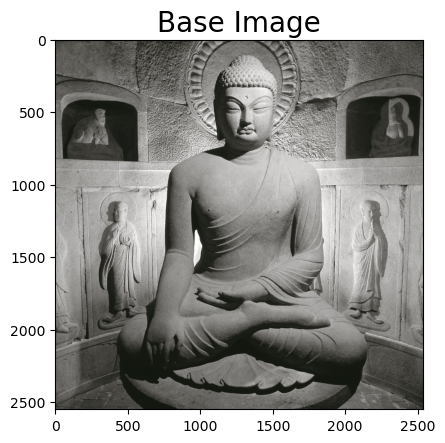

In [109]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(ContentPath+'1.jpg')
plt.imshow(img1)

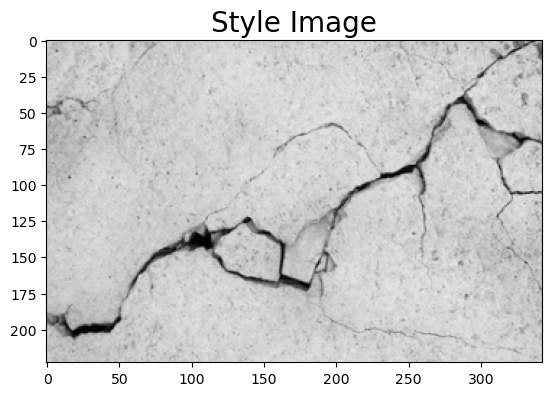

In [110]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(StylePath+'균열2.png')
plt.imshow(img1)

In [111]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [112]:
K.image_data_format()

'channels_last'

In [113]:
img_ncols, img_nrows

(397, 400)

In [114]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [115]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

  <tf.Variable 'Variable:0' shape=(1, 400, 397, 3) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.


### Building the VGG19 model

In [116]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = VGG19(weights='imagenet')
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights='imagenet')
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [117]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [118]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

KerasTensor(type_spec=TensorSpec(shape=(3, 25, 24, 512), dtype=tf.float32, name=None), name='block5_conv2/Relu:0', description="created by layer 'block5_conv2'")


### The content Loss
###### Given a chosen content layer l, the content loss is defined as the Mean Squared Error between the feature map F of our content image C and the feature map P of our generated image Y.

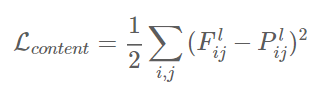

In [119]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

### The Style Loss
###### To do this at first we need to, calculate the Gram-matrix(a matrix comprising of correlated features) for the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer. If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image. If the feature map is a matrix F, then each entry in the Gram matrix G can be given by: 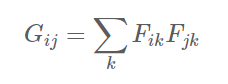

###### The loss function for style is quite similar to out content loss, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.
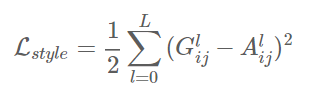

In [120]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))

In [121]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss = loss + content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

Layer Feature for Content Layers :: KerasTensor(type_spec=TensorSpec(shape=(3, 25, 24, 512), dtype=tf.float32, name=None), name='block5_conv2/Relu:0', description="created by layer 'block5_conv2'")
Base Image Feature :: KerasTensor(type_spec=TensorSpec(shape=(25, 24, 512), dtype=tf.float32, name=None), name='tf.__operators__.getitem_136/strided_slice:0', description="created by layer 'tf.__operators__.getitem_136'")
Combination Image Feature for Content Layers:: KerasTensor(type_spec=TensorSpec(shape=(25, 24, 512), dtype=tf.float32, name=None), name='tf.__operators__.getitem_137/strided_slice:0', description="created by layer 'tf.__operators__.getitem_137'")

Layer Feature for Style Layers :: KerasTensor(type_spec=TensorSpec(shape=(3, 400, 397, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
Style Image Feature :: KerasTensor(type_spec=TensorSpec(shape=(400, 397, 64), dtype=tf.float32, name=None), name='tf.__operators__.geti

In [122]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [123]:
import tensorflow as tf

# 이미지의 크기를 지정합니다.
img_nrows = 400  # 예시 값
img_ncols = 400  # 예시 값

# 이전에 K.image_data_format() == 'channels_first'를 사용한 조건에 따라 초기값을 설정합니다.
if tf.keras.backend.image_data_format() == 'channels_first':
    initial_value = tf.random.uniform((1, 3, img_nrows, img_ncols))
else:
    initial_value = tf.random.uniform((1, img_nrows, img_ncols, 3))

# combination_image를 tf.Variable로 정의합니다.
combination_image = tf.Variable(initial_value)


In [124]:
import tensorflow as tf
import numpy as np

# 가정: 필요한 모든 변수와 함수가 이미 정의되어 있음 -  정의해놧음 위에
# 예: get_content_loss, get_style_loss, gram_matrix 등

# 생성된 이미지를 tf.Variable로 정의합니다 (예시입니다) -위에 있음
#combination_image = tf.Variable(tf.random.uniform([1, img_nrows, img_ncols, 3]))

with tf.GradientTape() as tape:
    tape.watch(combination_image)
    # 손실을 계산하는 기존 코드를 여기에 포함합니다.
    # 손실 계산 로직은 위에서 제공된 코드를 그대로 사용합니다.
    loss = K.variable(0.0)
    # Content loss
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * get_content_loss(base_image_features, combination_features)
    # Style loss
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = get_style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl

# 손실에 대한 생성된 이미지의 그래디언트를 계산합니다.
grads = tape.gradient(loss, combination_image)

# grads를 사용하여 이미지를 업데이트하는 최적화 코드를 이어서 작성할 수 있습니다.


AttributeError: 'KerasTensor' object has no attribute '_id'

In [ ]:
combination_image.shape

TensorShape([1, 400, 400, 3])

In [ ]:
import tensorflow as tf
import numpy as np



# Gram 행렬 함수
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(a, a, transpose_a=True)
    return gram

# 스타일 손실 함수
def get_style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (3.0 ** 2) * (size ** 2))

# 손실 함수 초기화
total_loss = tf.Variable(0.0)

# 컨텐츠 및 스타일 가중치
content_weight = 0.025
style_weight = 1.0

# 컨텐츠 손실 및 스타일 손실을 계산하고 총 손실에 추가하는 과정
# 여기서 outputs_dict, get_content_loss, feature_layers는 사전에 정의되어 있어야 합니다.

# 생성 이미지를 tf.Variable로 정의
initial_value = tf.random.uniform((1, img_nrows, img_ncols, 3))
combination_image = tf.Variable(initial_value)

with tf.GradientTape() as tape:
    # 예시: 컨텐츠 손실 계산
    # 이 부분은 실제 컨텐츠 손실을 계산하는 코드로 대체해야 합니다.
    content_loss = content_weight * get_content_loss(base_image_features, combination_features)
    
    # 스타일 손실 계산
    style_loss = tf.Variable(0.0)
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss.assign_add((style_weight / len(feature_layers)) * get_style_loss(style_reference_features, combination_features))
    
    # 총 손실 계산
    total_loss.assign(content_loss + style_loss)

# 손실에 대한 그래디언트 계산
grads = tape.gradient(total_loss, combination_image)

# 이제 grads와 combination_image를 사용하여 최적화기를 통해 이미지를 업데이트할 수 있습니다.


ValueError: Exception encountered when calling layer "tf.math.subtract_21" (type TFOpLambda).

Dimensions must be equal, but are 400 and 25 for '{{node tf.math.subtract_21/Sub}} = Sub[T=DT_FLOAT](Placeholder, Placeholder_1)' with input shapes: [400,397,64], [25,24,512].

Call arguments received by layer "tf.math.subtract_21" (type TFOpLambda):
  • x=tf.Tensor(shape=(400, 397, 64), dtype=float32)
  • y=tf.Tensor(shape=(25, 24, 512), dtype=float32)
  • name=None

In [ ]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [ ]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [67]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
import numpy as np

# 이미지 경로 설정
StylePath = "C:/Users/User/풍화/풍화/"
ContentPath = "C:/Users/User/풍화/문화재/"

base_image_path = ContentPath + '1.jpg'
style_image_path = StylePath + '균열2.png'

# 이미지 사이즈 조절을 위한 함수
def load_and_process_img(image_path, img_nrows, img_ncols):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 생성 이미지의 차원을 컨텐츠 이미지 기준으로 설정
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 이미지 전처리
base_image = load_and_process_img(base_image_path, img_nrows, img_ncols)
style_image = load_and_process_img(style_image_path, img_nrows, img_ncols)

# 생성 이미지 (노이즈 추가)
import tensorflow as tf
random_img = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128.0
combination_image = tf.Variable(random_img, dtype=tf.float32)


In [68]:
# VGG19 모델 로드
model = vgg19.VGG19(include_top=False, weights='imagenet')
model.trainable = False

# 모델의 각 층 이름
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# 스타일 및 컨텐츠 특징을 추출할 층 선택
style_layer_names = [
    'block1_conv1', 'block2_conv1',
    'block3_conv1', 'block4_conv1',
    'block5_conv1'
]
content_layer_name = 'block5_conv2'


In [69]:
# 손실 함수를 정의하는 부분입니다. 여기서는 컨텐츠 손실과 스타일 손실을 계산하는 함수가 필요합니다.
# 예시로, 컨텐츠 손실을 계산하는 함수는 다음과 같습니다:

def content_loss(content, combination):
    return tf.reduce_sum(tf.square(combination - content))

# 스타일 손실 계산을 위한 Gram 행렬 함수
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# 스타일 손실 함수
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


In [72]:
# TensorFlow의 optimizers를 사용하여 최적화합니다.
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# 최적화를 수행하는 함수
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        # 손실 계산 로직을 추가합니다.
        # 여기서는 예시로 content_loss와 style_loss를 계산하고 이를 총 손실로 합칩니다.
        total_loss = 0.3*content_loss(base_image, combination_image) + 0.7*style_loss(style_image, combination_image)
    grads = tape.gradient(total_loss, image)
    optimizer.apply_gradients([(grads, image)])
    image.assign(tf.clip_by_value(image, -128, 127))

# 학습 과정
import time
start = time.time()

epochs = 8000
for i in range(epochs):
    train_step(combination_image)
    print(f"Epoch {i} completed")

end = time.time()
print(f"Total time: {end - start}s")


Epoch 0 completed
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epoch 37 completed
Epoch 38 completed
Epoch 39 completed
Epoch 40 completed
Epoch 41 completed
Epoch 42 completed
Epoch 43 completed
Epoch 44 completed
Epoch 45 completed
Epoch 46 completed
Epoch 47 completed
Epoch 48 completed
Epoch 49 completed
Epoch 50 completed
Epoch 51 completed
Epoch 52 completed
Epo

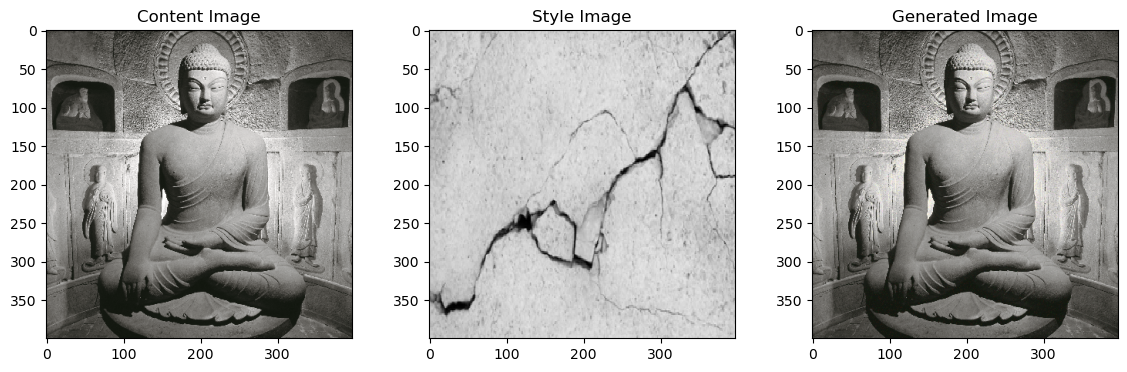

In [73]:
from matplotlib import pyplot as plt

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# 생성된 이미지를 시각화
plt.figure(figsize=(14, 4))

# 컨텐츠 이미지
plt.subplot(1, 3, 1)
plt.imshow(deprocess_img(base_image))
plt.title('Content Image')

# 스타일 이미지
plt.subplot(1, 3, 2)
plt.imshow(deprocess_img(style_image))
plt.title('Style Image')

# 생성된 이미지
plt.subplot(1, 3, 3)
plt.imshow(deprocess_img(combination_image.numpy()))
plt.title('Generated Image')

plt.show()

# 결과 이미지 저장
#result_img = deprocess_img(combination_image.numpy())
#save_img_path = "/mnt/data/generated_image.jpg"
#plt.imsave(save_img_path, result_img)


In [64]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np

# 이미지 경로 설정
ContentPath = "C:/Users/User/풍화/문화재/"
StylePath = "C:/Users/User/풍화/풍화/"

# 이미지 로딩 및 전처리를 위한 함수
def load_and_process_img(image_path, img_nrows, img_ncols):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 이미지 사이즈 조절을 위한 함수
width, height = load_img(ContentPath + '1.jpg').size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 이미지 로드 및 전처리
base_image = load_and_process_img(ContentPath + '1.jpg', img_nrows, img_ncols)
style_image = load_and_process_img(StylePath + '균열2.png', img_nrows, img_ncols)


In [65]:
# VGG19 모델 로드 및 중간 층 출력 추출
model = vgg19.VGG19(weights='imagenet', include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
style_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
style_outputs = [outputs_dict[name] for name in style_layer_names]
content_layer_name = 'block5_conv2'
content_output = outputs_dict[content_layer_name]
model = Model(inputs=model.inputs, outputs=style_outputs + [content_output])


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Style weight: 0.02, Content weight: 0.03


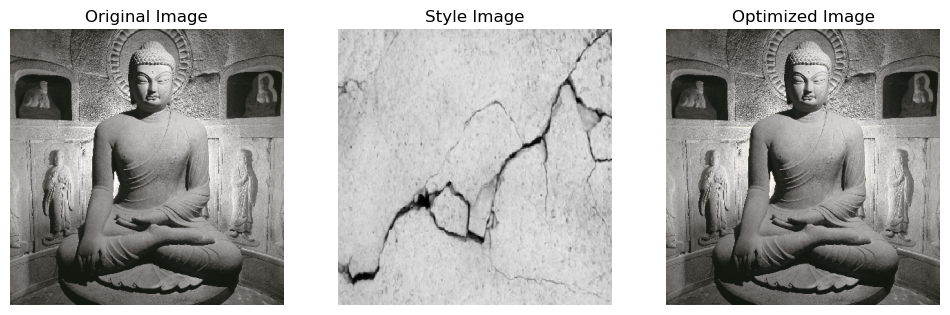

In [66]:
# Gram 행렬 및 손실 함수 정의
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def compute_style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def compute_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# 컨텐츠 및 스타일 특징 추출
def compute_features(model, content_image, style_image):
    style_outputs = model(style_image)[:-1]
    content_output = model(content_image)[-1]
    style_features = [gram_matrix(feature) for feature in style_outputs]
    return style_features, content_output

style_features, content_feature = compute_features(model, base_image, style_image)

# 컨텐츠 손실 및 스타일 손실을 계산하는 함수
def compute_loss(model, init_image, style_features, content_feature, style_weight=2.0, content_weight=0.025):
    style_weights = 1.0
    outputs = model(init_image)
    style_output_features = outputs[:-1]
    content_output_feature = outputs[-1]
    
    style_score = sum([compute_style_loss(sf, cof) for sf, cof in zip(style_features, style_output_features)])
    content_score = compute_content_loss(content_feature, content_output_feature)
    
    total_loss = style_weight * style_score + content_weight * content_score
    return total_loss

# 최적화를 위한 설정
optimizer = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)
style_weights = 1.0
'''
# 스타일 가중치와 컨텐츠 가중치 조절 예시
#style_weights = [0.01, 0.02, 0.05]
#content_weights = [0.01, 0.02, 0.03]

for style_weight in style_weights:
    for content_weight in content_weights:
        # 최적화를 위한 반복 실행 함수
        @tf.function
        def train_step(image):
            with tf.GradientTape() as tape:
                loss = compute_loss(model, image, style_features, content_feature)
            grads = tape.gradient(loss, image)
            optimizer.apply_gradients([(grads, image)])
            image.assign(tf.clip_by_value(image, -128, 127))

        # 초기 이미지 설정 및 최적화 실행
        combination_image = tf.Variable(base_image, dtype=tf.float32)
        epochs = 20  # 반복 횟수
        for i in range(epochs):
            train_step(combination_image)
            print(f"Epoch {i}")
        show_images_with_changes(style_weight, content_weight)
'''
# 최적화를 위한 반복 실행 함수
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, image, style_features, content_feature)
    grads = tape.gradient(loss, image)
    optimizer.apply_gradients([(grads, image)])
    image.assign(tf.clip_by_value(image, -128, 127))

# 초기 이미지 설정 및 최적화 실행
combination_image = tf.Variable(base_image, dtype=tf.float32)
epochs = 20  # 반복 횟수
for i in range(epochs):
    train_step(combination_image)
    print(f"Epoch {i}")
show_images_with_changes(style_weight, content_weight)


In [63]:
style_weight

0.02

1/1 [==============================] - 0s 48ms/step


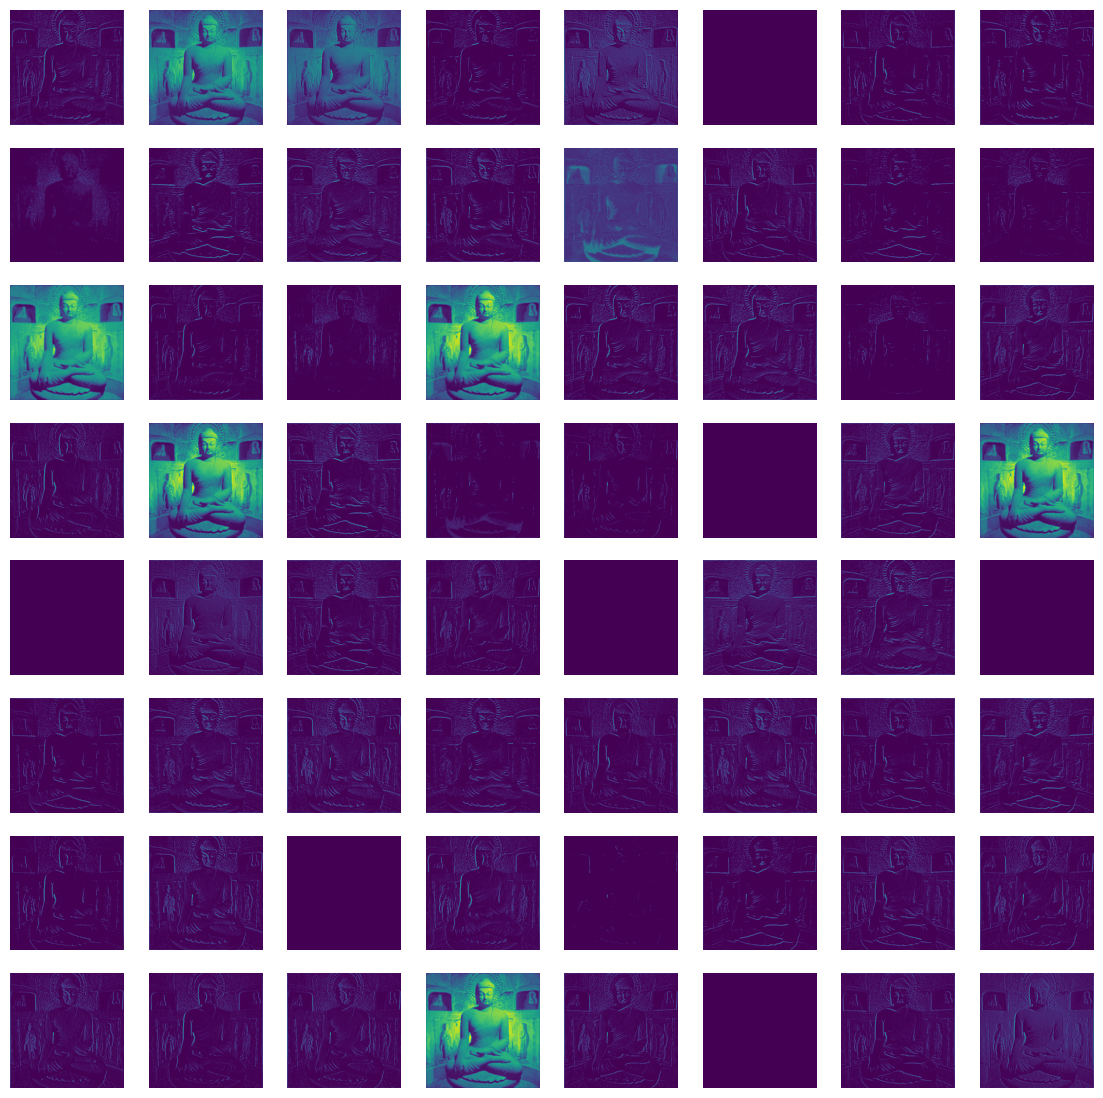

In [60]:
import matplotlib.pyplot as plt

# 특정 층의 출력을 시각화하는 함수
def visualize_feature_map(model, layer_name, image):
    # 모델 수정: 원하는 층의 출력만을 가져오도록
    layer_output = model.get_layer(layer_name).output
    activation_model = Model(inputs=model.input, outputs=layer_output)
    
    # 이미지를 모델에 통과시킴
    activation = activation_model.predict(image)
    
    # 특정 특징 맵 선택
    first_layer_activation = activation[0]
    
    # 특징 맵 시각화
    plt.figure(figsize=(14, 14))
    for i in range(first_layer_activation.shape[-1]):  # 채널 수만큼 반복
        plt.subplot(8, 8, i+1)  # 64개의 필터를 시각화한다고 가정
        plt.imshow(first_layer_activation[:, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

# 예시로 'block1_conv1' 층의 특징 맵 시각화
visualize_feature_map(model, 'block1_conv1', base_image)


In [61]:
def deprocess_image(x):
    # VGG19의 preprocess_input 함수에서 수행한 전처리를 반전시킵니다.
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # BGR을 RGB로 변환
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def show_images_with_changes(style_weight, content_weight):
    # 스타일 및 컨텐츠 가중치에 따라 최적화된 이미지 생성
    # 이 부분에서는 최적화 프로세스를 실행하는 코드를 포함해야 합니다.
    # 예제 코드는 최적화 프로세스를 단순화하여 표시합니다. 실제로는 여기에 최적화 코드를 삽입해야 합니다.
    # 예: train_step(combination_image), 여기서 combination_image는 최적화할 이미지입니다.
    print(f"Style weight: {style_weight}, Content weight: {content_weight}")
    
    # 원본 이미지, 스타일 이미지, 최적화된 이미지를 나란히 표시
    plt.figure(figsize=(12, 4))
    
    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(deprocess_image(base_image[0]))
    plt.title("Original Image")
    plt.axis('off')
    
    # 스타일 이미지
    plt.subplot(1, 3, 2)
    plt.imshow(deprocess_image(style_image[0]))
    plt.title("Style Image")
    plt.axis('off')
    
    # 최적화된 이미지
    plt.subplot(1, 3, 3)
    # 최적화 프로세스 후에 combination_image를 업데이트 해야 합니다.
    optimized_img = combination_image.numpy()  # 최적화 프로세스 후의 이미지
    plt.imshow(deprocess_image(optimized_img[0]))
    plt.title("Optimized Image")
    plt.axis('off')
    
    plt.show()